#  Basic demonstration of pyMCR

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from pymcr.mcr import McrAls, McrAls_NNLS

# Define model system

## Spectra

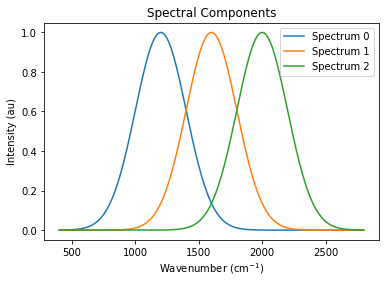

In [2]:
wn = np.linspace(400,2800,200)

n_components = 3

sp0 = np.exp(-(wn-1200)**2/(2*200**2))
sp1 = np.exp(-(wn-1600)**2/(2*200**2))
sp2 = np.exp(-(wn-2000)**2/(2*200**2))

plt.plot(wn, sp0, label='Spectrum 0')
plt.plot(wn, sp1, label='Spectrum 1')
plt.plot(wn, sp2, label='Spectrum 2')
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.legend(loc='best')
plt.title('Spectral Components')

## Concentration map

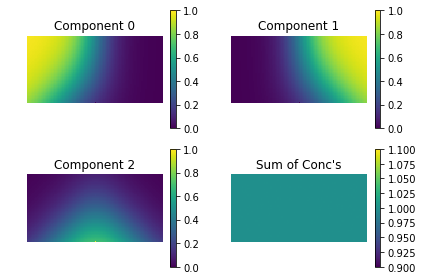

In [3]:
# Model starts off as 3 2D-Gaussian centered at (x*, y*)
# with standard deviation R (1 for each component).
# The sum to 1 constraint is then enforced.

x0 = 25
y0 = 25

x1 = 75
y1 = 25

x2 = 50
y2 = 50

R = 20

M=50  # rows (Y)
N= 100  # cols (X)

# Init concentration map
conc = np.zeros((M,N,n_components))

X,Y = np.meshgrid(np.arange(N), np.arange(M))

conc[...,0] = np.exp(-(X-x0)**2/(2*R**2))*np.exp(-(Y-y0)**2/(2*R**2))
conc[...,1] = np.exp(-(X-x1)**2/(2*R**2))*np.exp(-(Y-y1)**2/(2*R**2))
conc[...,2] = np.exp(-(X-x2)**2/(2*R**2))*np.exp(-(Y-y2)**2/(2*R**2))

conc /= conc.sum(axis=-1)[:,:,None]

# Find the maximum concentration (per component)
# and set to conc = 1 (and make the rest 0's)
# This just ensures that each component has a pure
# pixel somewhere within the image
for num in range(n_components):
    idx = np.unravel_index(conc[...,num].argmax(), conc[...,num].shape)
    tmp = np.zeros(3)
    tmp[num] = 1
    conc[idx[0],idx[1],:] = 1*tmp

plt.figure(figsize=(6,4))
for num in range(3):
    plt.subplot(2,2,num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    plt.title('Component {}'.format(num))

plt.subplot(2,2,4)
plt.imshow(conc.sum(axis=-1))
plt.colorbar()
plt.axis('off')
plt.title('Sum of Conc\'s')
plt.tight_layout()

In [4]:
# Stack 3 spectral vectors into 1 matrix
spectra = np.vstack((sp0, sp1, sp2))

# Hyperspectral image (HSI)
hsi = np.dot(conc, spectra)

# Perform MCR-ALS

## With spectral guess

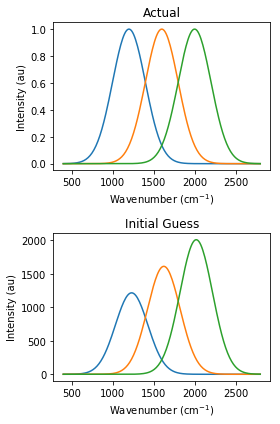

In [5]:
# Poor guess
initial_spectra = spectra*wn

plt.figure(figsize=(4,6))
plt.subplot(211)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(212)
plt.plot(wn, initial_spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Initial Guess')

plt.tight_layout()

In [6]:
mcrals = McrAls(max_iter=200, tol_mse=1e-7, tol_dif_conc=1e-6, tol_dif_spect=1e-8)
mcrals.fit(hsi.reshape((-1, wn.size)), initial_spectra=initial_spectra)
print('\nFinal MSE: {:.7e}'.format(mcrals.mse[-1]))
print('Final C_MRD: {:.7e}'.format(mcrals._c_mrd))
print('Final ST_MRD: {:.7e}'.format(mcrals._st_mrd))

iteration 1 : MSE 3.88e-04
iteration 2 : MSE 8.11e-05
iteration 3 : MSE 3.15e-05
iteration 4 : MSE 1.71e-05
iteration 5 : MSE 1.10e-05
iteration 6 : MSE 7.69e-06
iteration 7 : MSE 5.66e-06
iteration 8 : MSE 4.33e-06
iteration 9 : MSE 3.41e-06
iteration 10 : MSE 2.74e-06
iteration 11 : MSE 2.25e-06
iteration 12 : MSE 1.87e-06
iteration 13 : MSE 1.58e-06
iteration 14 : MSE 1.35e-06
iteration 15 : MSE 1.17e-06
iteration 16 : MSE 1.01e-06
iteration 17 : MSE 8.90e-07
iteration 18 : MSE 7.86e-07
iteration 19 : MSE 6.99e-07
iteration 20 : MSE 6.24e-07
iteration 21 : MSE 5.61e-07
iteration 22 : MSE 5.07e-07
iteration 23 : MSE 4.61e-07
iteration 24 : MSE 4.20e-07
iteration 25 : MSE 3.84e-07
iteration 26 : MSE 3.53e-07
iteration 27 : MSE 3.25e-07
iteration 28 : MSE 3.01e-07
iteration 29 : MSE 2.79e-07
iteration 30 : MSE 2.60e-07
iteration 31 : MSE 2.42e-07
iteration 32 : MSE 2.27e-07
iteration 33 : MSE 2.13e-07
iteration 34 : MSE 2.00e-07
iteration 35 : MSE 1.88e-07
iteration 36 : MSE 1.78e-07
i

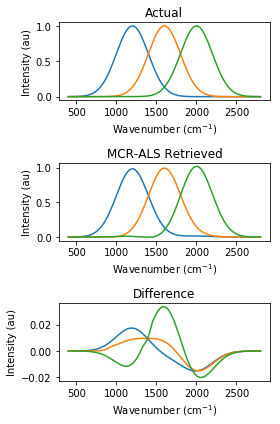

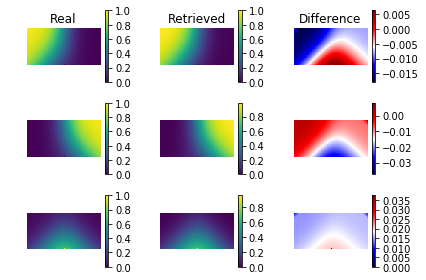

In [7]:
plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(312)
plt.plot(wn, mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-ALS Retrieved')

plt.subplot(313)
plt.plot(wn, spectra.T - mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

temp = mcrals.conc_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout()
plt.show()

## With concentration guess

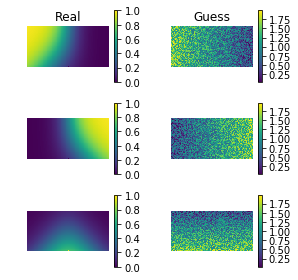

In [8]:
# Poor guess
initial_conc = np.zeros((M,N,3))
initial_conc[...,0] = np.dot(np.ones(M)[:,None], (np.arange(N,0,-1)/N)[None,:])
initial_conc[...,1] = np.dot(np.ones(M)[:,None], (np.arange(N)/N)[None,:])
initial_conc[...,2] = np.dot((np.arange(M)/M)[:,None], np.ones(N)[None,:])
initial_conc += np.random.rand(M,N,3)

plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(initial_conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Guess')
plt.tight_layout()
    
# plt.figure(figsize=(4,6))
# plt.subplot(211)
# plt.plot(wn, spectra.T)
# plt.xlabel(r'Wavenumber (cm$^{-1}$)')
# plt.ylabel('Intensity (au)')
# plt.title('Actual')

# plt.subplot(212)
# plt.plot(wn, initial_spectra.T)
# plt.xlabel(r'Wavenumber (cm$^{-1}$)')
# plt.ylabel('Intensity (au)')
# plt.title('Initial Guess')

# plt.tight_layout()

In [9]:
mcrals = McrAls(max_iter=200, tol_mse=1e-7, tol_dif_conc=1e-7, tol_dif_spect=1e-7)
mcrals.fit(hsi.reshape((-1, wn.size)), initial_conc=initial_conc.reshape((-1, 3)))
print('\nFinal MSE: {:.7e}'.format(mcrals.mse[-1]))
print('Final C_MRD: {:.7e}'.format(mcrals._c_mrd))
print('Final ST_MRD: {:.7e}'.format(mcrals._st_mrd))

iteration 1 : MSE 2.10e-02
iteration 2 : MSE 4.57e-03
iteration 3 : MSE 4.31e-04
iteration 4 : MSE 1.28e-04
iteration 5 : MSE 5.99e-05
iteration 6 : MSE 3.59e-05
iteration 7 : MSE 2.47e-05
iteration 8 : MSE 1.84e-05
iteration 9 : MSE 1.45e-05
iteration 10 : MSE 1.18e-05
iteration 11 : MSE 9.85e-06
iteration 12 : MSE 8.43e-06
iteration 13 : MSE 7.36e-06
iteration 14 : MSE 6.51e-06
iteration 15 : MSE 5.84e-06
iteration 16 : MSE 5.30e-06
iteration 17 : MSE 4.84e-06
iteration 18 : MSE 4.46e-06
iteration 19 : MSE 4.14e-06
iteration 20 : MSE 3.86e-06
iteration 21 : MSE 3.62e-06
iteration 22 : MSE 3.40e-06
iteration 23 : MSE 3.21e-06
iteration 24 : MSE 3.04e-06
iteration 25 : MSE 2.89e-06
iteration 26 : MSE 2.75e-06
iteration 27 : MSE 2.63e-06
iteration 28 : MSE 2.51e-06
iteration 29 : MSE 2.41e-06
iteration 30 : MSE 2.31e-06
iteration 31 : MSE 2.22e-06
iteration 32 : MSE 2.14e-06
iteration 33 : MSE 2.06e-06
iteration 34 : MSE 1.99e-06
iteration 35 : MSE 1.92e-06
iteration 36 : MSE 1.86e-06
i

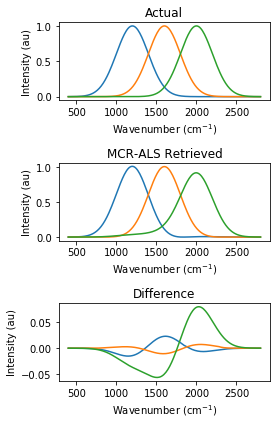

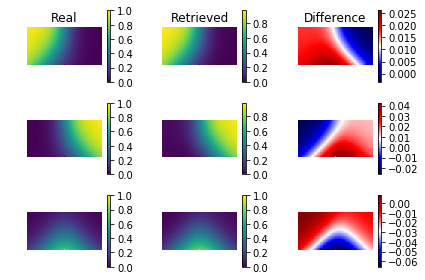

In [10]:
plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(312)
plt.plot(wn, mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-ALS Retrieved')

plt.subplot(313)
plt.plot(wn, spectra.T - mcrals.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

temp = mcrals.conc_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout()
plt.show()

# Alterantive methods

## NNLS Implementation

### Spectral Guessing

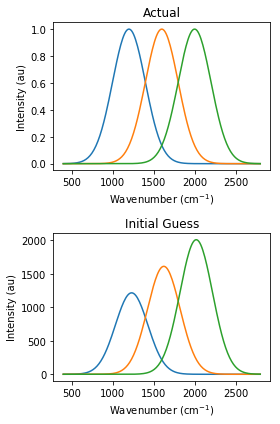

In [11]:
# Poor guess
initial_spectra = spectra*wn

plt.figure(figsize=(4,6))
plt.subplot(211)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(212)
plt.plot(wn, initial_spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Initial Guess')

plt.tight_layout()

In [12]:
mcrals_nnls = McrAls_NNLS(max_iter=100, tol_mse=1e-7, tol_dif_conc=1e-6, tol_dif_spect=1e-8)
mcrals_nnls.fit(hsi.reshape((-1, wn.size)), initial_spectra=initial_spectra)
print('\nFinal MSE: {:.7e}'.format(mcrals.mse[-1]))
print('Final C_MRD: {:.7e}'.format(mcrals._c_mrd))
print('Final ST_MRD: {:.7e}'.format(mcrals._st_mrd))

iteration 1 : MSE 2.81e-04
iteration 2 : MSE 9.38e-05
iteration 3 : MSE 5.40e-05
iteration 4 : MSE 3.68e-05
iteration 5 : MSE 2.68e-05
iteration 6 : MSE 2.04e-05
iteration 7 : MSE 1.59e-05
iteration 8 : MSE 1.27e-05
iteration 9 : MSE 1.03e-05
iteration 10 : MSE 8.54e-06
iteration 11 : MSE 7.14e-06
iteration 12 : MSE 6.04e-06
iteration 13 : MSE 5.16e-06
iteration 14 : MSE 4.45e-06
iteration 15 : MSE 3.87e-06
iteration 16 : MSE 3.39e-06
iteration 17 : MSE 2.98e-06
iteration 18 : MSE 2.64e-06
iteration 19 : MSE 2.36e-06
iteration 20 : MSE 2.11e-06
iteration 21 : MSE 1.90e-06
iteration 22 : MSE 1.72e-06
iteration 23 : MSE 1.56e-06
iteration 24 : MSE 1.42e-06
iteration 25 : MSE 1.30e-06
iteration 26 : MSE 1.19e-06
iteration 27 : MSE 1.09e-06
iteration 28 : MSE 1.01e-06
iteration 29 : MSE 9.33e-07
iteration 30 : MSE 8.65e-07
iteration 31 : MSE 8.04e-07
iteration 32 : MSE 7.49e-07
iteration 33 : MSE 6.99e-07
iteration 34 : MSE 6.54e-07
iteration 35 : MSE 6.13e-07
iteration 36 : MSE 5.76e-07
i

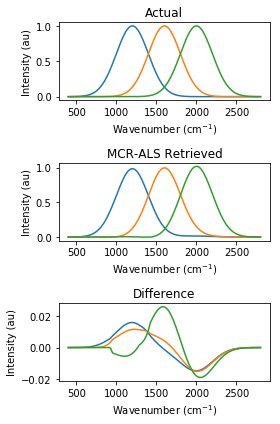

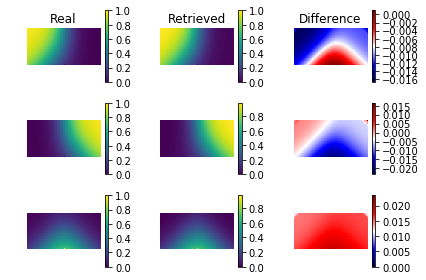

In [13]:
plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(312)
plt.plot(wn, mcrals_nnls.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-ALS Retrieved')

plt.subplot(313)
plt.plot(wn, spectra.T - mcrals_nnls.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

temp = mcrals_nnls.conc_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout()
plt.show()

### Concentration guessing

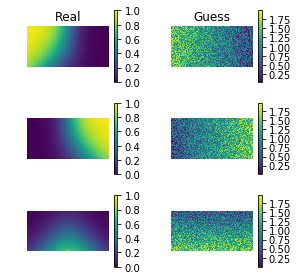

In [14]:
# Poor guess
initial_conc = np.zeros((M,N,3))
initial_conc[...,0] = np.dot(np.ones(M)[:,None], (np.arange(N,0,-1)/N)[None,:])
initial_conc[...,1] = np.dot(np.ones(M)[:,None], (np.arange(N)/N)[None,:])
initial_conc[...,2] = np.dot((np.arange(M)/M)[:,None], np.ones(N)[None,:])
initial_conc += np.random.rand(M,N,3)

plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(initial_conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Guess')
plt.tight_layout()
    
# plt.figure(figsize=(4,6))
# plt.subplot(211)
# plt.plot(wn, spectra.T)
# plt.xlabel(r'Wavenumber (cm$^{-1}$)')
# plt.ylabel('Intensity (au)')
# plt.title('Actual')

# plt.subplot(212)
# plt.plot(wn, initial_spectra.T)
# plt.xlabel(r'Wavenumber (cm$^{-1}$)')
# plt.ylabel('Intensity (au)')
# plt.title('Initial Guess')

# plt.tight_layout()

In [15]:
mcrals_nnls = McrAls_NNLS(max_iter=200, tol_mse=1e-7, tol_dif_conc=1e-7, tol_dif_spect=1e-7)
mcrals_nnls.fit(hsi.reshape((-1, wn.size)), initial_conc=initial_conc.reshape((-1, 3)))
print('\nFinal MSE: {:.7e}'.format(mcrals.mse[-1]))
print('Final C_MRD: {:.7e}'.format(mcrals._c_mrd))
print('Final ST_MRD: {:.7e}'.format(mcrals._st_mrd))

iteration 1 : MSE 1.79e-02
iteration 2 : MSE 5.41e-03
iteration 3 : MSE 6.43e-04
iteration 4 : MSE 2.18e-04
iteration 5 : MSE 1.15e-04
iteration 6 : MSE 7.00e-05
iteration 7 : MSE 4.64e-05
iteration 8 : MSE 3.25e-05
iteration 9 : MSE 2.37e-05
iteration 10 : MSE 1.79e-05
iteration 11 : MSE 1.39e-05
iteration 12 : MSE 1.10e-05
iteration 13 : MSE 8.93e-06
iteration 14 : MSE 7.36e-06
iteration 15 : MSE 6.16e-06
iteration 16 : MSE 5.23e-06
iteration 17 : MSE 4.50e-06
iteration 18 : MSE 3.91e-06
iteration 19 : MSE 3.43e-06
iteration 20 : MSE 3.04e-06
iteration 21 : MSE 2.72e-06
iteration 22 : MSE 2.45e-06
iteration 23 : MSE 2.22e-06
iteration 24 : MSE 2.03e-06
iteration 25 : MSE 1.86e-06
iteration 26 : MSE 1.72e-06
iteration 27 : MSE 1.60e-06
iteration 28 : MSE 1.49e-06
iteration 29 : MSE 1.39e-06
iteration 30 : MSE 1.31e-06
iteration 31 : MSE 1.24e-06
iteration 32 : MSE 1.17e-06
iteration 33 : MSE 1.11e-06
iteration 34 : MSE 1.06e-06
iteration 35 : MSE 1.01e-06
iteration 36 : MSE 9.70e-07
i

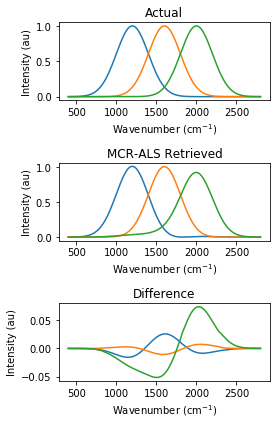

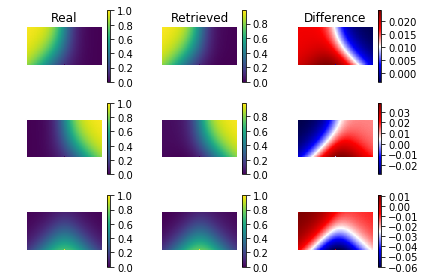

In [16]:
plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(312)
plt.plot(wn, mcrals_nnls.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-ALS Retrieved')

plt.subplot(313)
plt.plot(wn, spectra.T - mcrals_nnls.spectra_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

temp = mcrals_nnls.conc_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout()
plt.show()